In [14]:
import sys
import os
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import numpy as np
import matplotlib.pyplot as plt

# SVR
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# NN with dropout/early stopping/adam #adagrad opti.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping #, LearningRateScheduler

In [2]:
#cpuserver_data_FP/TCA_ML_project_SB/small_X_temp.npy
#cpuserver_data_FP/TCA_ML_project_SB/small_y_temp.npy
X = np.load( f'{cpuserver_data_FP}/TCA_ML_project_SB/small_X_temp.npy')
y = np.load( f'{cpuserver_data_FP}/TCA_ML_project_SB/small_y_temp.npy')

Epoch 1/60


/opt/miniconda3/envs/hydroai/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - loss: 0.6918 - mae: 0.4302 - val_loss: 0.5396 - val_mae: 0.3665
Epoch 2/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - loss: 0.5367 - mae: 0.3717 - val_loss: 0.4703 - val_mae: 0.3532
Epoch 3/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - loss: 0.4940 - mae: 0.3622 - val_loss: 0.4047 - val_mae: 0.3439
Epoch 4/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step - loss: 0.4793 - mae: 0.3601 - val_loss: 0.3844 - val_mae: 0.3413
Epoch 5/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - loss: 0.4534 - mae: 0.3570 - val_loss: 0.3589 - val_mae: 0.3357
Epoch 6/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - loss: 0.4179 - mae: 0.3515 - val_loss: 0.3442 - val_mae: 0.3294
Epoch 7/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step - loss: 0.4213 - mae: 0.3484 - val_loss: 0.3230 - val_mae: 0.3278
Epoch 8/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - loss: 0.4063 - mae: 0.3469 - val_loss: 0.3445 - val_mae: 0.3293
Epoch 9/60
2000/2000 ━━━━━━━━━━━━━━

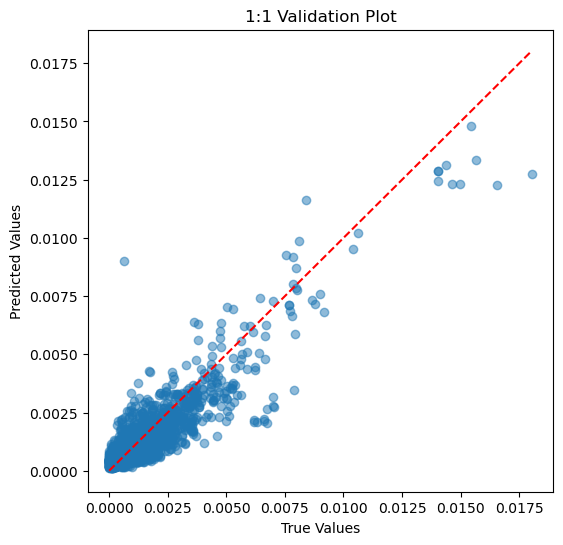

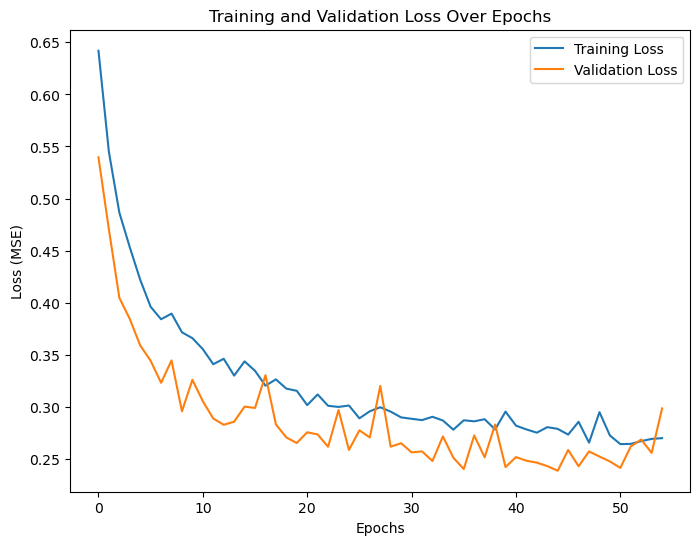

In [18]:
# NN
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

## Subin: You need to scale the feature data.
## Compare the results with scaled vs. non-scaled
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
#
## Optionally, scale the target data (this is more common for certain types of regression problems)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Comment in when you test the scaled vs non-scaled
#X_train_scaled = X_train
#X_test_scaled  = X_test
#y_train_scaled = y_train
#y_test_scaled  = y_test

# Define the model with Dropout layers
model = Sequential([
    Dense(64, input_shape=(20,), activation='relu'),  # First hidden layer with 64 neurons
    Dropout(0.2),                                     # Dropout layer with 20% dropout rate
    Dense(32, activation='relu'),                     # Second hidden layer with 32 neurons
    Dropout(0.2),                                     # Dropout layer with 20% dropout rate
    Dense(1)                                          # Output layer for regression (no activation)
])

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',               # Mean Squared Error loss for regression
              metrics=['mae'])          # Mean Absolute Error as a metric

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train_scaled, 
                    epochs=60, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping],  # Add early stopping to the training process
                    verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test MAE: {mae:.4f}")

# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions and the true values to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# 1:1 Validation Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='red', linestyle='--')  # 1:1 line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('1:1 Validation Plot')
plt.show()

# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Mean Squared Error: 1.74349531686174e-07
R^2 Score: 0.5966342764787738


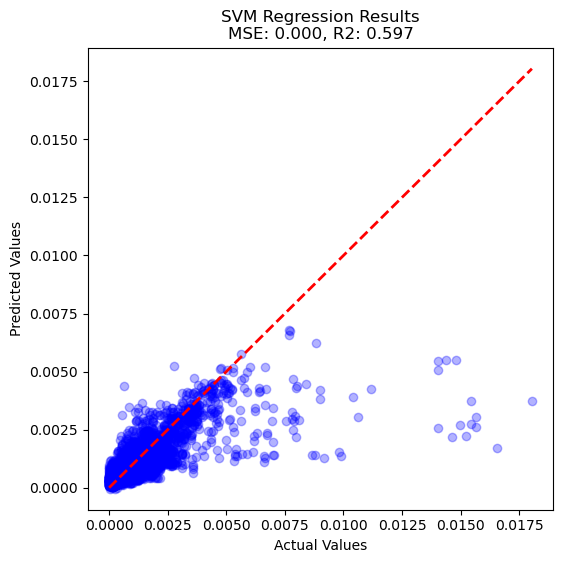

In [6]:
# SVR
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=321)

# Scale X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Create and fit the SVR model
model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions to get them back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'SVM Regression Results\nMSE: {mse:.3f}, R2: {r2:.3f}')
plt.show()